### Flight Price Prediction

#### Hackathon by Machinehack

#### Problem : 
Predict the prices of flight tickets for various airlines given informations like Journey date, source, destination, departure and arrival time, route, total stops and some additional flight information

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost
import datetime as dt\
import re

In [2]:
# Import Data

df = pd.read_excel('Data_Train.xlsx',sheet_name='Sheet1')

In [ ]:
# User Defined Functions

# Convert dates in text format to hour
def get_hr_text(x):  
    lst = x.split(' ')
    hr = int(lst[0].replace('h','')) if list(lst[0])[-1] == 'h' else 0
    mn = int(lst[0].replace('m','')) if list(lst[0])[-1] == 'm' else int(lst[1].replace('m','')) if len(lst)==2 else 0
    return(hr + round(mn/60,2))

# Convert dates in text format to hour and minute separately
def get_hr_text2(x):  
    lst = x.split(' ')
    hr = int(lst[0].replace('h','')) if list(lst[0])[-1] == 'h' else 0
    mn = int(lst[0].replace('m','')) if list(lst[0])[-1] == 'm' else int(lst[1].replace('m','')) if len(lst)==2 else 0
    return(hr ,mn)

# Count plot
def cntplot(varname):    
    total = len(df)*1
    ax = sns.countplot(varname, data=df)
    for p in ax.patches:
            ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
    plt.show()

# Get the days difference from nearest holiday    
def hold_days(x,hlist):
    daysdiff = [abs((x - a).days) for a in hlist]
    return(daysdiff[daysdiff.index(min(daysdiff))])

# Count number of stops from a given route
def get_route(x,i):
    z = str(x).split()
    final = list(map(lambda y : re.sub('[^a-zA-Z]+', '', y),z))
    final = list(filter(None,final))
    if(len(final) == 3):
        s1 = final[1]
        s2 = None
    elif(len(final) == 4):
        s1 = final[1]
        s2 = final[2]
    else:
        s1 = None
        s2 = None
    if i==1:
        rt=s1
    else:
        rt=s2
    return rt

#### Data Checks and variable creation

In [3]:
# Count of rows at unqiue key level to check duplicates
df['fn'] = df.groupby(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info']).transform('count')

In [4]:
# Holiday calender
holdf = pd.read_excel('Data_Train.xlsx',sheet_name='Sheet2')
holdf['Date_of_Journey'] = pd.to_datetime(holdf['DATE'],format='%d-%m-%Y')

In [5]:
hold_dates = holdf.Date_of_Journey.unique()
hold_dates = list(map(pd.to_datetime,hold_dates))

In [8]:
# Duration
durhr = df['Duration'].apply(lambda x : get_hr_text2(x)[0])
durm = df['Duration'].apply(lambda x : get_hr_text2(x)[1])

In [9]:
# Remove Duplicates
df1 = df.drop_duplicates().reset_index(inplace=False)
print(len(df1))
df1.head()

10463


,index,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,fn
0,0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,1.0
1,1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1.0
2,2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,1.0
3,3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,1.0
4,4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1.0


In [195]:
df = pd.DataFrame(df1.groupby(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],as_index=False)['Price'].max())

In [10]:
df=df1

In [26]:
df.head()

,index,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,...,holiday_flag2,long_layover,baggage,arr_len,day_change,day_change2,days,hdays,stop1,stop2
0,0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,...,1,0,0,12,-2,1,23,3,None,None
1,1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,...,0,0,0,5,0,0,61,0,IXR,BBI
2,2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,...,0,0,0,12,1,1,100,4,LKO,BOM
3,3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,...,0,0,0,5,0,0,72,6,NAG,None
4,4,IndiGo,2019-03-01,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,...,0,0,0,5,0,0,0,20,NAG,None


In [12]:
df.loc[df['Route'].isnull(),'Total_Stops'] = '1 stop'

In [13]:
df['Arrival_Time2'] = pd.to_datetime(df['Dep_Time'], format='%H:%M') + durhr.apply(lambda x : dt.timedelta(hours=x)) + durm.apply(lambda x : dt.timedelta(minutes=x))

In [15]:
# Variable Creation for model

df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y')
df['journey_month'] = df['Date_of_Journey'].dt.month_name()
df['dep_hour'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour + pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.minute/60
df['arr_hour'] = pd.to_datetime(df['Arrival_Time2']).dt.hour + pd.to_datetime(df['Arrival_Time2']).dt.minute/60
df['dur'] = df['Duration'].apply(lambda x : get_hr_text(x))
df['dow'] = df.Date_of_Journey.dt.day_name()
df['Additional_Info'] = df['Additional_Info'].apply(lambda x : x.lower())
df['Destination'] = np.where(df['Destination'] == 'New Delhi','Delhi',df['Destination'])
df['lprice'] = df['Price'].apply(lambda x : np.log(x))
df['ldur'] = df['dur'].apply(lambda x : np.log(x))
df['dep_hour_bucket'] = ['RedEye' if x in range(0,7) else 'Morn' if x in range(7,11) else 'Noon' if x in range(11,15) else 'Eve' 
if x in range(15,19) else 'Eve2' if x in range(19,21) else 'Night' if x in range(21,24) else None for x in df['dep_hour']]
df.loc[:,'Total_Stops1'] = ['Multiple' if x in ['2 stops','3 stops', '4 stops'] else x for x in df.loc[:,'Total_Stops']]
df.loc[:,'No_Meal'] = np.where(df['Additional_Info'] == 'in-flight meal not included',1,0)
df['holiday_flag'] = [1 if set([x]).intersection(hold_dates) else 0 for x in df['Date_of_Journey']]
df['holiday_flag2'] = [1 if set([x - dt.timedelta(3),x - dt.timedelta(2),x - dt.timedelta(1),x + dt.timedelta(1),x + dt.timedelta(2),x + dt.timedelta(3)]).intersection(hold_dates) else 0 for x in df['Date_of_Journey']]
#df['holiday_flag2'] = np.where(df['dow'].isin(['Saturday','Sunday']),df['holiday_flag2'],0)
df['long_layover'] = np.where((df['Additional_Info'] == '1 long layover') | (df['Additional_Info'] == '2 long layover'),1,0)
df['baggage'] = np.where((df['Additional_Info'] == 'no check-in baggage included'),1,0)
df['arr_len'] = df['Arrival_Time'].apply(len)
df['day_change'] = np.where(df['arr_len'] > 5 , pd.to_datetime(df['Arrival_Time']).dt.day - df['Date_of_Journey'].dt.day,0)
df['day_change2'] = np.where(df['day_change'] == 0,0,1)

In [16]:
# Create a variable for days counter
mindate = df['Date_of_Journey'].min()
df['days'] = [(df['Date_of_Journey'][i]-mindate).days for i in  range(len(df))]

In [18]:
df['hdays'] = df['Date_of_Journey'].apply(lambda x : hold_days(x,hold_dates))

In [19]:
df = df[(df.Airline != 'Trujet') & (df.dur > 1)]
len(df)

10461

In [25]:
df['stop1'] = df['Route'].apply(lambda x : get_route(x,1))
df['stop2'] = df['Route'].apply(lambda x : get_route(x,2))

C:\Users\suvajit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\suvajit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


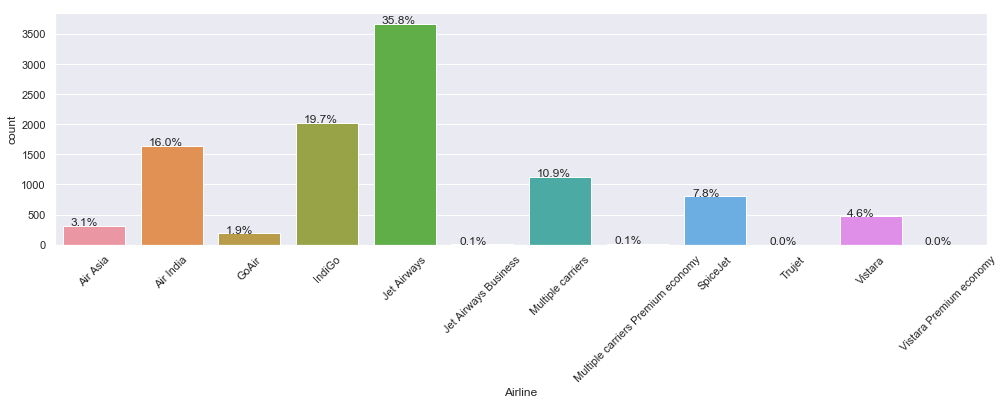

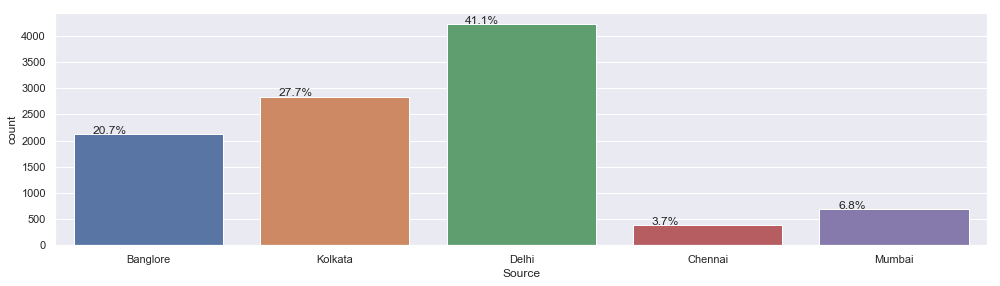

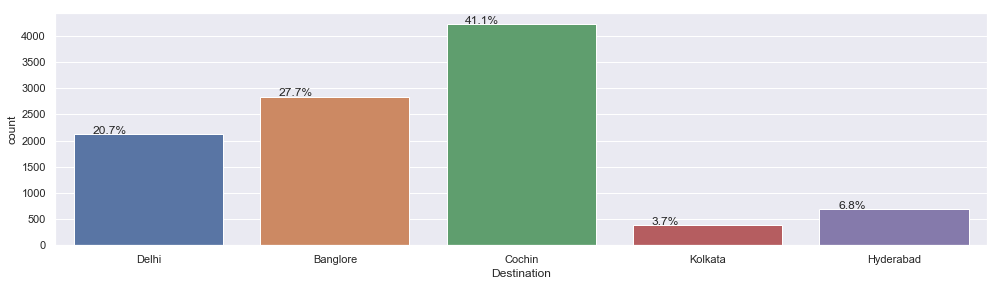

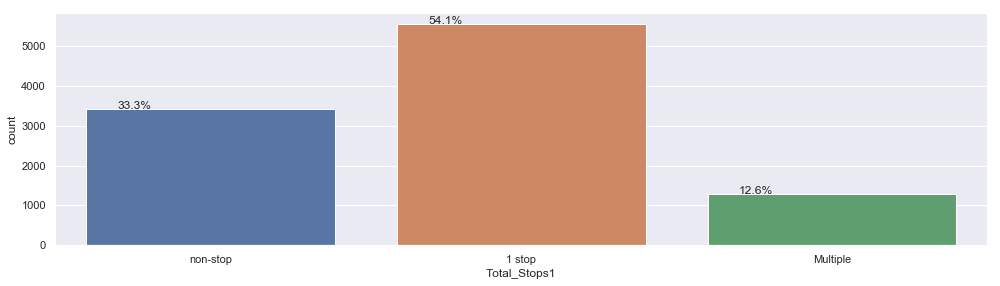

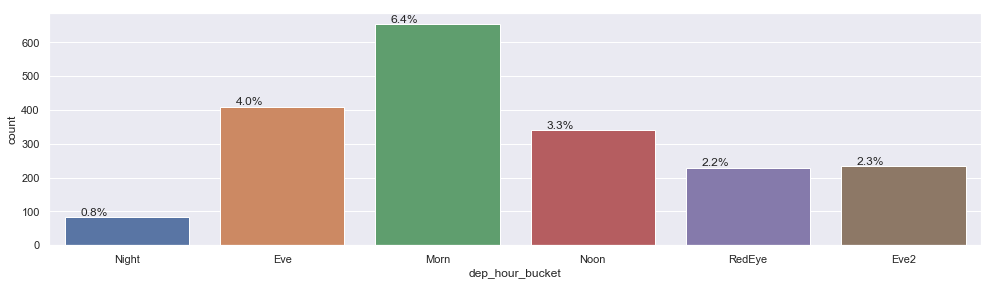

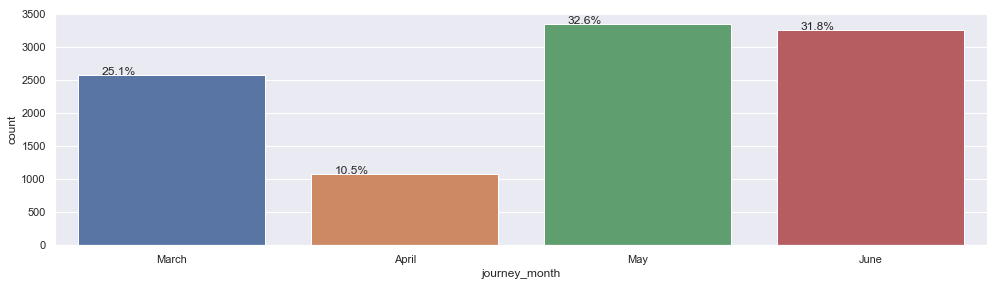

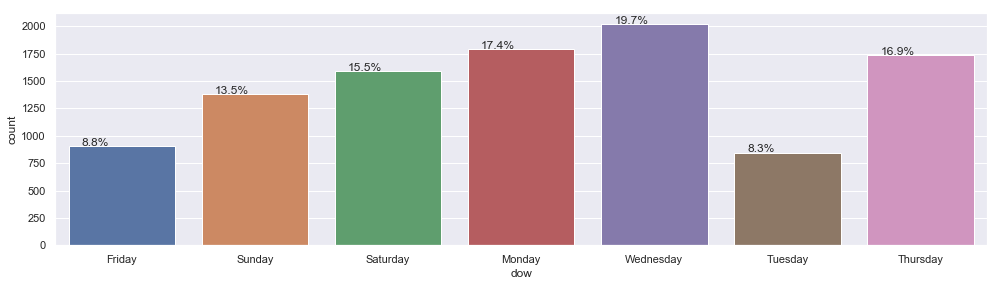

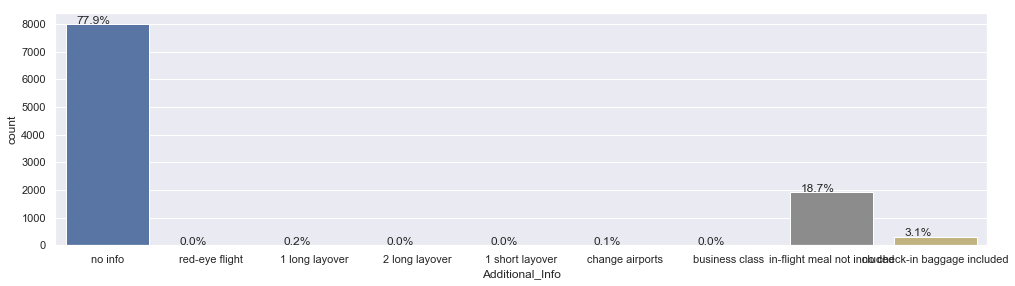

In [15]:
sns.set(rc={'figure.figsize':(16.7,4.27)})
plt.xticks(rotation=45)
cntplot('Airline')
cntplot('Source')
cntplot('Destination')
cntplot('Total_Stops1')
cntplot('dep_hour_bucket')
cntplot('journey_month')
cntplot('dow')
cntplot('Additional_Info')

In [16]:
def priceplot(varname):    
    sns.set(font_scale = 1)
    total = len(df)*1
    gr = pd.DataFrame(df.groupby(varname)['Price'].mean())
    gr.reset_index(inplace=True)
    ax = sns.barplot(x=varname, y='Price', data=gr)
    i=0
    for p in ax.patches:
        ax.annotate(round(gr.Price[i]), (p.get_x()+0.1, p.get_height()+5))
        i+=1
    plt.show()

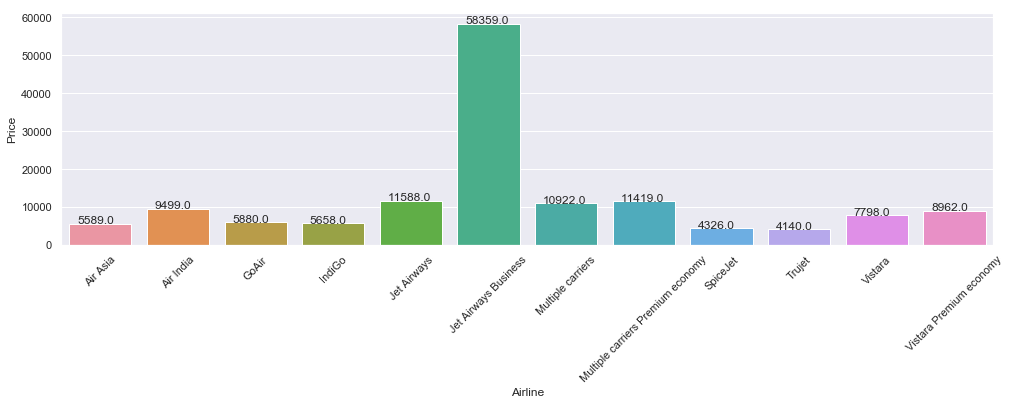

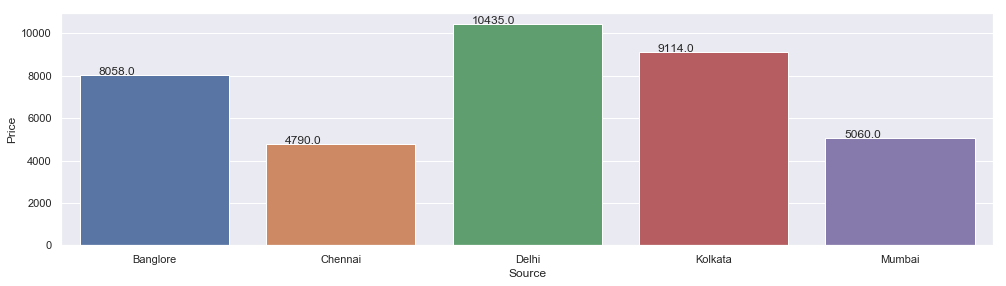

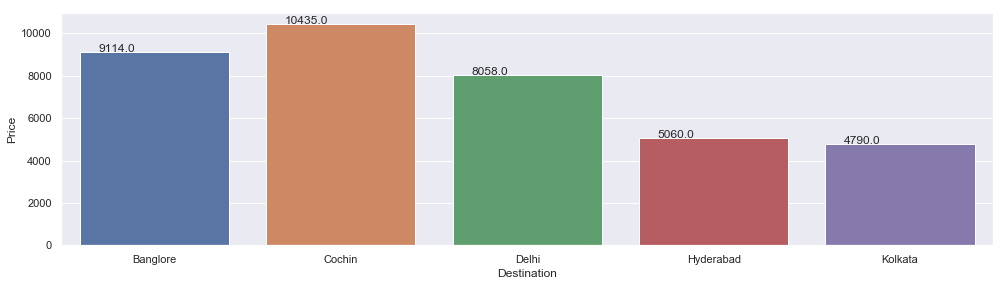

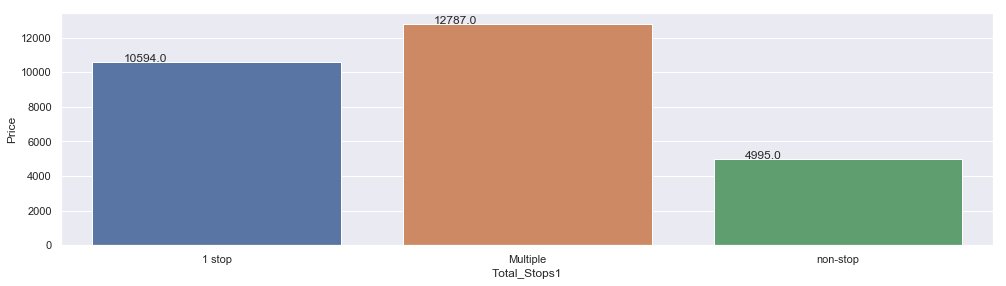

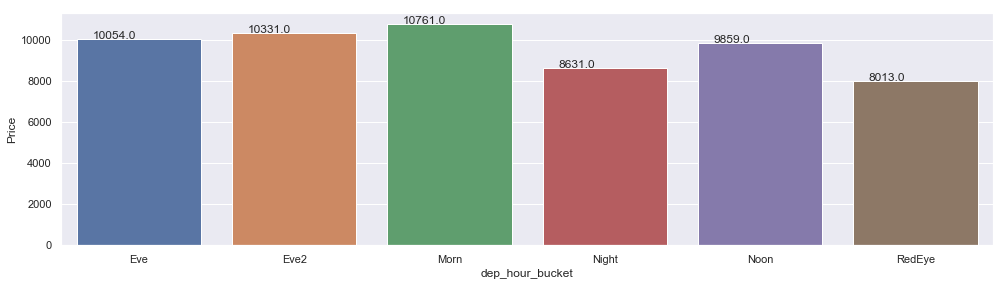

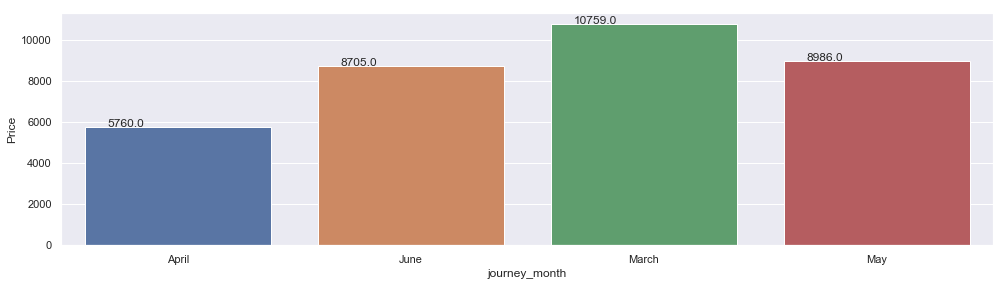

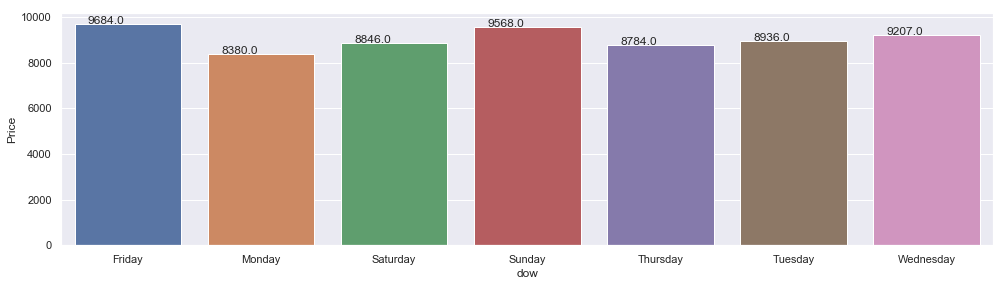

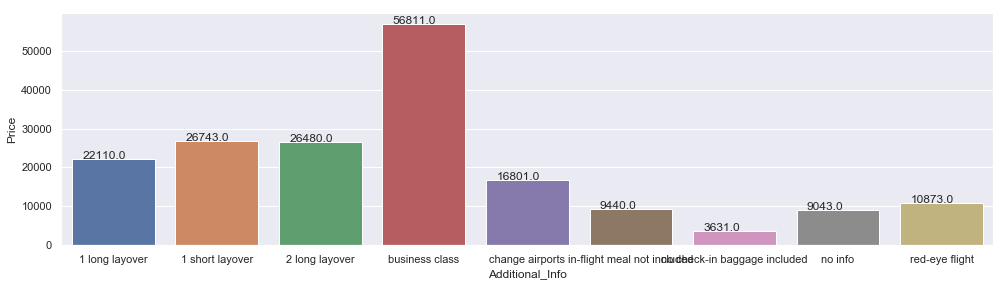

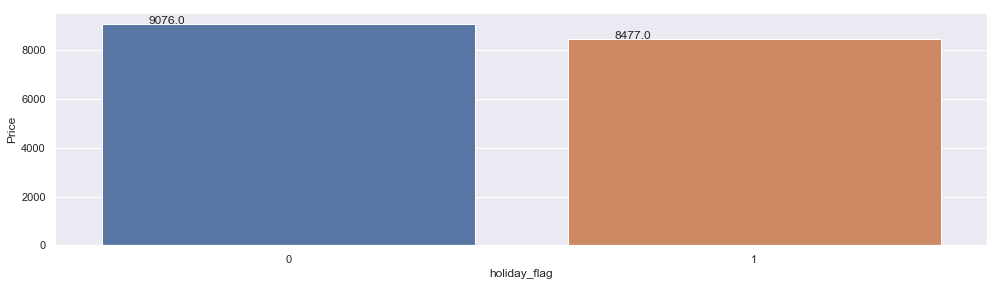

In [798]:
sns.set(rc={'figure.figsize':(16.7,4.27)})
plt.xticks(rotation=45)
priceplot('Airline')
priceplot('Source')
priceplot('Destination')
priceplot('Total_Stops1')
priceplot('dep_hour_bucket')
priceplot('journey_month')
priceplot('dow')
priceplot('Additional_Info')
priceplot('holiday_flag')

In [86]:
df.columns
x_vars = ['Airline', 'Source', 'Destination','Total_Stops1','dep_hour', 'ldur', 'journey_month', 'dow','arr_hour','holiday_flag','Additional_Info','days','hdays','fn','stop1','stop2']

In [87]:
# Convert into categorical data type
for i in x_vars:
    if i not in ['ldur','dep_hour','arr_hour','days','hdays']:
        df.loc[:,i] = df.loc[:,i].astype('category')

C:\Users\suvajit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [129]:
# Create Dummies
cat_vars = ['Airline', 'Source', 'Destination','Total_Stops1','journey_month', 'dow','No_Meal','holiday_flag','baggage','stop1','stop2','fn']
cont_vars = ['dep_hour', 'ldur','arr_hour','days','hdays']
dumm_data = pd.get_dummies(df[cat_vars], drop_first=True)
x_final1 = pd.concat([dumm_data,df[cont_vars]],axis=1)
#x_final1 = x_final1.drop(columns='Airline_Trujet')
x_final1 = x_final1.drop(['stop1_RPR', 'stop1_JLR', 'stop1_VTZ', 'stop1_IXZ', 'stop1_IXA'],axis=1)

#### Light GBM Model

In [88]:
Y = df['lprice']
X = df[x_vars]
#X = x_final1

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [122]:
lgbm_model=lightgbm.LGBMRegressor(boosting_type='gbdt',n_jobs=-1,learning_rate=0.08,n_estimators=1200, feature_fraction=0.5,num_leaves=200,max_depth = 7,
                                  reg_alpha=0.02,reg_lambda=10,objective='regression',metric='rmse',seed=42)
lgbm_model.fit(X_train,y_train)
#lgbm_model.fit(X,Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.08,
       max_depth=7, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1200,
       n_jobs=-1, num_leaves=200, objective='regression',
       random_state=None, reg_alpha=0.02, reg_lambda=10, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [123]:
scores = cross_val_score(lgbm_model,X_train, y_train,cv=5)

In [124]:
scores

array([0.94446547, 0.95283608, 0.94423384, 0.93444446, 0.94688726])

In [125]:
pred1=lgbm_model.predict(X_test)
predtrain=lgbm_model.predict(X_train)

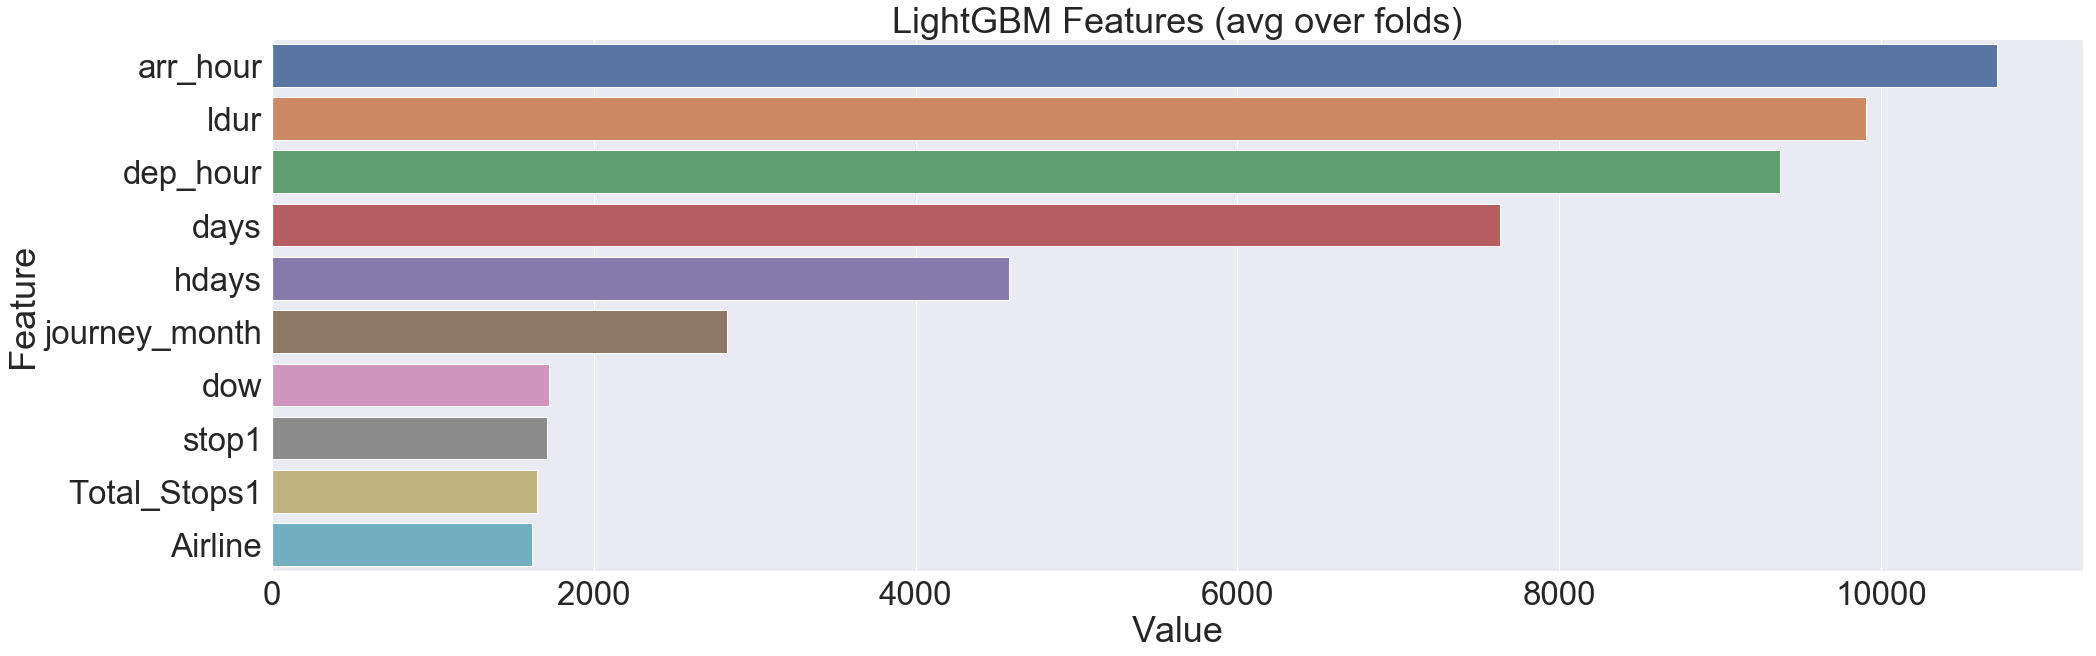

In [126]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(30, 10))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False).head(10))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [127]:
rms_test = sqrt(mean_squared_error(y_test, pred1))
#rms_test = sqrt(mean_squared_error(y_test.apply(lambda x : np.log(x)), pd.DataFrame(pred1).apply(lambda x : np.log(x))))
rms_train = sqrt(mean_squared_error(y_train, predtrain))
print('train error : ' + str(rms_train))
print('test error : ' + str(rms_test))

train error : 0.05617353995611738
test error : 0.11207376526940553


In [249]:
parameters = {'learning_rate':[0.2],'n_estimators':[800],'feature_fraction':[0.4,0.5,0.6]
              ,'num_leaves':[100],'max_depth' : [7,8,9],'reg_alpha' : [0.05,0.1,0.2,0.3],reg_lambda=[0.5,1,1.5,2,3,4]}
lgb_GS = GridSearchCV(lgbm_model, parameters, cv=5)
lgb_GS.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       feature_fraction=0.8, importance_type='split', learning_rate=0.25,
       max_depth=6, metric='rmse', min_child_samples=10,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, nthread=3, num_leaves=100, objective='regression',
       random_state=None, reg_alpha=2, reg_lambda=8, seed=42, silent=True,
       subsample=1.0, subsample_for_bin=200, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.25], 'n_estimators': [800, 1000, 1200], 'feature_fraction': [0.4, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [250]:
lgb_GS.best_params_

{'feature_fraction': 0.6, 'learning_rate': 0.25, 'n_estimators': 800}

In [128]:
#final model
lgbm_model.fit(X,Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.08,
       max_depth=7, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1200,
       n_jobs=-1, num_leaves=200, objective='regression',
       random_state=None, reg_alpha=0.02, reg_lambda=10, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

### XGB Model

In [130]:
Y = df['lprice']
X = x_final1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [131]:
xgb_model=xgboost.XGBRegressor(learning_rate=0.1,n_estimators=800, feature_fraction=0.8,max_depth = 25,reg_alpha=0.01,reg_lambda=5,colsample_bytree=0.9
                               ,gamma=0.01,seed=42)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, feature_fraction=0.8, gamma=0.01,
       learning_rate=0.1, max_delta_step=0, max_depth=25,
       min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=5, scale_pos_weight=1, seed=42,
       silent=True, subsample=1)

In [132]:
pred2=xgb_model.predict(X_test)
predtrain2=xgb_model.predict(X_train)

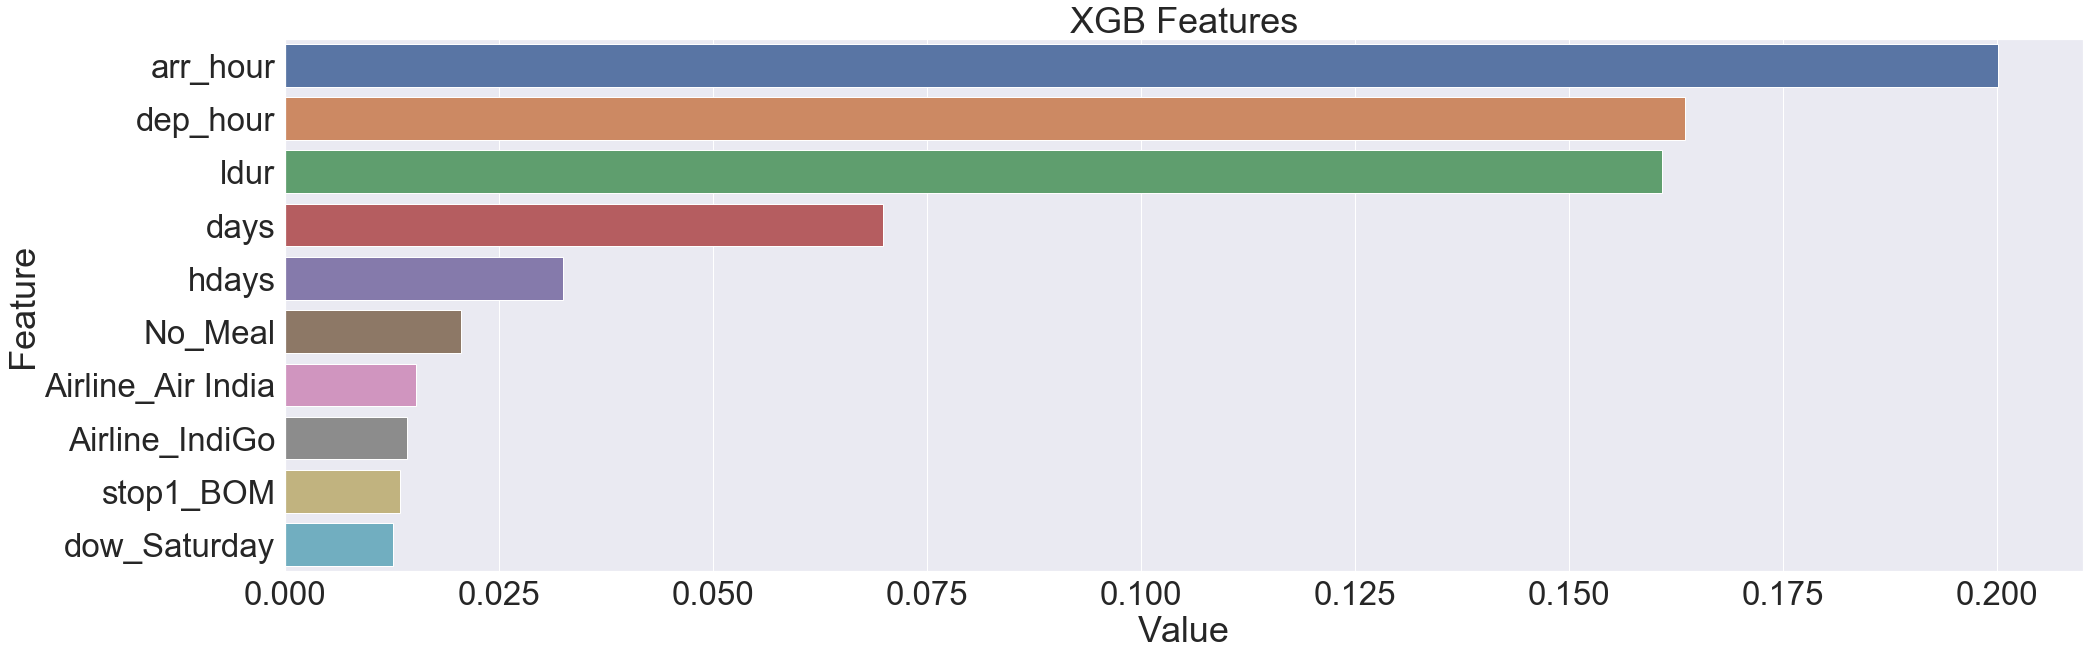

In [133]:
feature_imp = pd.DataFrame(sorted(zip(xgb_model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(30, 10))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False).head(10))
plt.title('XGB Features')
plt.tight_layout()
plt.show()

In [134]:
rms_test = sqrt(mean_squared_error(y_test, pred2))
rms_train = sqrt(mean_squared_error(y_train, predtrain2))
print('train error : ' + str(rms_train))
print('test error : ' + str(rms_test))

train error : 0.035323024376556336
test error : 0.1133923957234702


In [135]:
#final model
xgb_model.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, feature_fraction=0.8, gamma=0.01,
       learning_rate=0.1, max_delta_step=0, max_depth=25,
       min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=5, scale_pos_weight=1, seed=42,
       silent=True, subsample=1)

### Ensemble

In [136]:
pred_mean = [(0.5*pred1[i] + 0.5*pred2[i])/1 for i in range(len(pred1))]

In [137]:
rms_test = sqrt(mean_squared_error(y_test, pred_mean))
print('test error : ' + str(rms_test))

test error : 0.10884823157828867


In [553]:
from sklearn.model_selection import GridSearchCV

In [559]:
parameters = {'learning_rate':[0.05],'n_estimators':[1000],'max_depth' : [8],'reg_alpha':[0.1,0.3,0.5,0.7]}
xgb_GS = GridSearchCV(xgb_model, parameters, cv=5)
xgb_GS.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, feature_fraction=0.5, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.5,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05], 'n_estimators': [1000], 'max_depth': [8], 'reg_alpha': [0.1, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [583]:
pd.concat([X_test.reset_index(drop=True),pd.DataFrame(pred1),pd.DataFrame(y_test).reset_index(drop=True),],axis=1).to_csv('testpred.csv',sep=',')

In [177]:
from mlxtend.regressor import StackingRegressor

In [180]:
stg = StackingRegressor(regressors=[xgb_model, lgbm_model], meta_regressor=lgbm_model)

In [182]:
stg.fit(X_train,y_train)

StackingRegressor(meta_regressor=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       feature_fraction=0.7, importance_type='split', learning_rate=0.25,
       max_depth=9, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
       n...a=10, seed=42,
       silent=True, subsample=0.9, subsample_for_bin=200000,
       subsample_freq=0),
         refit=True,
         regressors=[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, feature_fraction=0.8, gamma=0.01,
       learning_rate=0.2, max_delta_step=0, max_depth=25,
       min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective...=10, seed=42,
       silent=True, subsample=0.9, subsample_for_bin=200000,
       subsample_freq=0)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [183]:
pred3=stg.predict(X_test)
predtrain3=stg.predict(X_train)

In [184]:
rms_test = sqrt(mean_squared_error(y_test, pred3))
rms_train = sqrt(mean_squared_error(y_train, predtrain3))
print('train error : ' + str(rms_train))
print('test error : ' + str(rms_test))

train error : 0.029043867938665487
test error : 0.1261592938992967


In [185]:
stg.fit(X,Y)

StackingRegressor(meta_regressor=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       feature_fraction=0.7, importance_type='split', learning_rate=0.25,
       max_depth=9, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
       n...a=10, seed=42,
       silent=True, subsample=0.9, subsample_for_bin=200000,
       subsample_freq=0),
         refit=True,
         regressors=[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, feature_fraction=0.8, gamma=0.01,
       learning_rate=0.2, max_delta_step=0, max_depth=25,
       min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
       nthread=None, objective...=10, seed=42,
       silent=True, subsample=0.9, subsample_for_bin=200000,
       subsample_freq=0)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

### Test data set

In [182]:
dftest = pd.read_excel('Test_set.xlsx',sheet_name='Sheet1')

In [183]:
dftest['unit'] = 1

In [185]:
dftest.loc[:,'fn'] = dftest.groupby(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route','Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops','Additional_Info']).transform('count')

In [186]:
dftest['fn'].unique()

array([nan])

In [168]:
dftest['Date_of_Journey'] = pd.to_datetime(dftest['Date_of_Journey'],format='%d/%m/%Y')
dftest['journey_month'] = dftest['Date_of_Journey'].dt.month_name()
dftest['dep_hour'] = pd.to_datetime(dftest['Dep_Time'], format='%H:%M').dt.hour + pd.to_datetime(dftest['Dep_Time'], format='%H:%M').dt.minute/60
dftest['arr_hour'] = pd.to_datetime(dftest['Arrival_Time']).dt.hour + pd.to_datetime(dftest['Arrival_Time']).dt.minute/60
dftest['dur'] = dftest['Duration'].apply(lambda x : get_hr_text(x))
dftest['dow'] = dftest.Date_of_Journey.dt.day_name()
dftest['Additional_Info'] = dftest['Additional_Info'].apply(lambda x : x.lower())
dftest['Destination'] = np.where(dftest['Destination'] == 'New Delhi','Delhi',dftest['Destination'])
dftest['dep_hour_bucket'] = ['RedEye' if x in range(0,7) else 'Morn' if x in range(7,10) else 'Noon' if x in range(11,15) else 'Eve' 
if x in range(15,19) else 'Eve2' if x in range(19,21) else 'Night' if x in range(21,24) else None for x in dftest['dep_hour']]
dftest['ldur'] = dftest['dur'].apply(lambda x : np.log(x))
dftest.loc[:,'Total_Stops1'] = ['Multiple' if x in ['2 stops', '3 stops', '4 stops'] else x for x in dftest.loc[:,'Total_Stops']]
dftest.loc[:,'No_Meal'] = np.where(dftest['Additional_Info'] == 'in-flight meal not included',1,0)
dftest['holiday_flag'] = [1 if set([x]).intersection(hold_dates) else 0 for x in dftest['Date_of_Journey']]
dftest['holiday_flag2'] = [1 if set([x - dt.timedelta(3),x - dt.timedelta(2),x - dt.timedelta(1),x + dt.timedelta(1),x + dt.timedelta(2),x + dt.timedelta(3)]).intersection(hold_dates) else 0 for x in dftest['Date_of_Journey']]
dftest['long_layover'] = np.where((dftest['Additional_Info'] == '1 long layover') | (dftest['Additional_Info'] == '2 long layover'),1,0)
dftest['baggage'] = np.where((dftest['Additional_Info'] == 'no check-in baggage included'),1,0)
dftest['arr_len'] = dftest['Arrival_Time'].apply(len)
dftest['day_change'] = np.where(dftest['arr_len'] > 5 , pd.to_datetime(dftest['Arrival_Time']).dt.day - dftest['Date_of_Journey'].dt.day,0)
dftest['day_change2'] = np.where(dftest['day_change'] == 0,0,1)

In [169]:
dftest['days'] = [(dftest['Date_of_Journey'][i]-mindate).days for i in  range(len(dftest))]

In [170]:
dftest['hdays'] = dftest['Date_of_Journey'].apply(lambda x : hold_days(x,hold_dates))

In [171]:
dftest['stop1'] = dftest['Route'].apply(lambda x : get_route(x,1))
dftest['stop2'] = dftest['Route'].apply(lambda x : get_route(x,2))

In [146]:
for i in x_vars:
    if i not in ['ldur','dep_hour','arr_hour','days','hdays']:
        dftest.loc[:,i] = dftest.loc[:,i].astype('category')

In [147]:
# Create Dummies (for XGB)
cat_vars = ['Airline', 'Source', 'Destination','Total_Stops1','journey_month', 'dow','No_Meal','holiday_flag','baggage','stop1','stop2']
cont_vars = ['dep_hour', 'ldur','arr_hour','days','hdays']
dumm_data = pd.get_dummies(dftest[cat_vars], drop_first=True)
x_final = pd.concat([dumm_data,dftest[cont_vars]],axis=1)
#x_final.drop(['stop1_RPR', 'stop1_JLR', 'stop1_VTZ', 'stop1_IXZ', 'stop1_IXA'],axis=1)
x_final = x_final.drop(['stop2_TIR'],axis=1)

In [148]:
predl=lgbm_model.predict(dftest[x_vars])
predx=xgb_model.predict(x_final)
pred_mean = [(predl[i]+predx[i])/2 for i in range(len(predl))]
#predx=stg.predict(x_final)
pred_price = pd.DataFrame(list(map(np.exp,predl)))
pred_price.columns = ['Price']

ValueError: feature_names mismatch: ['No_Meal', 'baggage', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Total_Stops1_Multiple', 'Total_Stops1_non-stop', 'journey_month_June', 'journey_month_March', 'journey_month_May', 'dow_Monday', 'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'holiday_flag_1', 'stop1_ATQ', 'stop1_BBI', 'stop1_BDQ', 'stop1_BHO', 'stop1_BLR', 'stop1_BOM', 'stop1_CCU', 'stop1_COK', 'stop1_DED', 'stop1_DEL', 'stop1_GAU', 'stop1_GOI', 'stop1_HYD', 'stop1_IDR', 'stop1_IXB', 'stop1_IXC', 'stop1_IXR', 'stop1_IXU', 'stop1_JAI', 'stop1_JDH', 'stop1_KNU', 'stop1_LKO', 'stop1_MAA', 'stop1_NAG', 'stop1_PAT', 'stop1_PNQ', 'stop1_STV', 'stop1_TRV', 'stop1_UDR', 'stop1_VGA', 'stop1_VNS', 'stop2_BBI', 'stop2_BHO', 'stop2_BOM', 'stop2_COK', 'stop2_DEL', 'stop2_GAU', 'stop2_GOI', 'stop2_HBX', 'stop2_HYD', 'stop2_IDR', 'stop2_ISK', 'stop2_IXC', 'stop2_JDH', 'stop2_MAA', 'stop2_NAG', 'stop2_PNQ', 'stop2_TRV', 'stop2_UDR', 'stop2_VGA', 'stop2_VTZ', 'fn_2.0', 'fn_3.0', 'fn_4.0', 'fn_5.0', 'dep_hour', 'ldur', 'arr_hour', 'days', 'hdays'] ['No_Meal', 'baggage', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Total_Stops1_Multiple', 'Total_Stops1_non-stop', 'journey_month_June', 'journey_month_March', 'journey_month_May', 'dow_Monday', 'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'holiday_flag_1', 'stop1_ATQ', 'stop1_BBI', 'stop1_BDQ', 'stop1_BHO', 'stop1_BLR', 'stop1_BOM', 'stop1_CCU', 'stop1_COK', 'stop1_DED', 'stop1_DEL', 'stop1_GAU', 'stop1_GOI', 'stop1_HYD', 'stop1_IDR', 'stop1_IXB', 'stop1_IXC', 'stop1_IXR', 'stop1_IXU', 'stop1_JAI', 'stop1_JDH', 'stop1_KNU', 'stop1_LKO', 'stop1_MAA', 'stop1_NAG', 'stop1_PAT', 'stop1_PNQ', 'stop1_STV', 'stop1_TRV', 'stop1_UDR', 'stop1_VGA', 'stop1_VNS', 'stop2_BBI', 'stop2_BHO', 'stop2_BOM', 'stop2_COK', 'stop2_DEL', 'stop2_GAU', 'stop2_GOI', 'stop2_HBX', 'stop2_HYD', 'stop2_IDR', 'stop2_ISK', 'stop2_IXC', 'stop2_JDH', 'stop2_MAA', 'stop2_NAG', 'stop2_PNQ', 'stop2_TRV', 'stop2_UDR', 'stop2_VGA', 'stop2_VTZ', 'dep_hour', 'ldur', 'arr_hour', 'days', 'hdays']
expected fn_3.0, fn_2.0, fn_4.0, fn_5.0 in input data

In [78]:
pred_price.to_excel('prediction21.xlsx')

In [79]:
pred_price.max()

Price    51156.652534
dtype: float64